#  Assignment 1 - Language Model Foundations

<div style="padding:15px 20px 20px 20px;border-left:3px solid green;background-color:#e4fae4;border-radius: 20px;color:#424242;">

Welcome to the **1st assignment** for the **CS-552: Modern NLP course**!

- 😀 Name: ** Malak Lahlou Nabil **
- ✉️ Email: ** malak.lahlounabil@epfl.ch**
- 🪪 SCIPER: **329571**

In the first two parts of this assignment, you need to construct a dataset and use it to train language models (LSTM and Transformer);

In the third part, you will finetune language models (RNN-based and Transformer-based Encoder-Decoder) on a text simplification task.

### **Tasks**
- **[PART 1: Data Preprocessing](#1)**
    - [1.1 Data Cleaning](#11)
    - [1.2 Build Vocabulary](#12)
    - [1.2 Get PyTorch Dataset](#13)
- **[PART 2: Training Language Models](#2)**
    - [2.1 Vanilla LSTM](#21)
    - [2.2 Transformer (DistilGPT2)](#22)
- **[PART 3: Finetuning Language Models](#3)**
    - [3.1 Encoder-Decoder Model](#31)
    - [3.2 Transformer (T5)](#32)


### **Deliverables**
- ✅ This Jupyter notebook
- ✅ `data.py`, `modeling.py` file
- ✅ Checkpoints for two LSTM-variant and DistilGPT2 language models (Part 2)
- ✅ Checkpoints for finetuned encoder-decoder and T5 language models (Part 3)
- ✅ `./tensorboard` directory with logs for all trained/finetuned models

Large files such as model checkpoints and logs should be pushed to the repository with Git LFS. You may also find that training the models on a GPU can speed up the process, we recommend using Colab's free GPU service for this. A tutorial on how to use Git LFS and Colab can be found [here](https://github.com/epfl-nlp/cs-552-modern-nlp/blob/main/Exercises/tutorials.md).

</div>

<div style="padding:15px 20px 20px 20px;border-left:3px solid orange;background-color:#fff5d6;border-radius: 20px;color:#424242;">

## How to implement this assignment

Please read carefully the following points. All the information on how to read, implement and submit your assignment is explained in detail below.

1. For this assignment, you will need to implement and fill in the missing code snippets for both the **Jupyter Notebook** `assignment1.ipynb` and the `data.py` and `modeling.py` python files. In the `data.py` and `modeling.py` files, you will add all the Dataset and Model classes you will implement according to the skeleton present in the files. In the notebook, you will use the definitions from those python files to prepare datasets, train and finetune models and add the report at the end.

2. To implement your coding part, you can import the external libraries we provide in the `requirements.txt` file, however, you should not use any other package not included in these requirements. We recommend using **python=3.10** for this assignment

3. At the end of the notebook, you will need to fill in a **report** template, providing the results of your implementation. We provide you with the template for the report, therefore you need to fill in the missing Markdown cells with the requested information.

4. Along with the `assignment1.ipynb` and the `data.py`, `modeling.py` files, you need to additionally upload model files under the `models/` dir, regarding the following models:
    - the two LSTM-variant models (PART 2)  
    - the trained-from-scratch DistilGPT2 model (PART 2)
    - the fine-tuned Encoder-Decoder model (PART 3)
    - the fine-tuned T5 model (PART 3)
    
You will provide test results on all of the model variants according to the report template.

5. Finally, you will need to log your training pipelines using Tensorboard. Please follow the instructions in the `README.md` of the [tensorboard/](tensorboard/README.md) directory.
</div>

In [ ]:
# This cell makes sure modules are auto-loaded when you change external python files
%load_ext autoreload
%autoreload 2

In [ ]:
# If you are working in Colab, then consider mounting your assignment folder to your drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# and change the path below to point to the assignment folder
%cd /content/drive/MyDrive/a1-2024-mimimamalah

/content/drive/MyDrive/a1-2024-mimimamalah


### Setup

In [ ]:
# I used V100 for GPU

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" # limiting to one GPU

In [ ]:
# I have some pip's dependency issues but it does not affect the assignement, please ignore.

In [ ]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 43.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 106.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 102.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:

from datasets import load_dataset
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import evaluate
import gensim
import transformers
import nltk

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;color:#424242;">

**TODO🔻: Enter your SCIPER number below!**
     
</div>

In [ ]:
import re
import random
import numpy as np
import torch

## Enter your SCIPER here: ##
SCIPER = "329571"

try:
    assert re.match("\d{6}", SCIPER)[0] == SCIPER, "Invalid SCIPER given. please enter your correct 6-digit SCIPER number above!"
except:
    print("Invalid SCIPER given. please enter your correct 6-digit SCIPER number above!")

student_seed = int(SCIPER)


"""Set seed for reproducibility."""
random.seed(student_seed)
np.random.seed(student_seed)
torch.manual_seed(student_seed)
torch.cuda.manual_seed_all(student_seed)

---

<a name="1"></a>
# PART 1: Data Preprocessing

We will train a language model using the `wikitext-103` dataset.

> `wikitext-103` dataset is a large collection of articles with verified
good and featured quality from Wikipedia. We will use the open-source dataset from Huggingface (https://huggingface.co/datasets/wikitext).

In [ ]:
from utils import *
from test_A1 import *
from data import filter_by_length, data_clean, count_tokens, build_vocabulary

### Load `wikitext-103` Dataset

In [ ]:
wikitext_dataset = load_dataset("wikitext", 'wikitext-103-v1', split="train")

print(f"Size of the dataset is {len(wikitext_dataset)}")

# You can print some samples to get a sense of the data
print(wikitext_dataset[0])
print(wikitext_dataset[10])
print(wikitext_dataset[100])

Size of the dataset is 1801350
{'text': ''}
{'text': ' The game \'s battle system , the <unk> system , is carried over directly from <unk> Chronicles . During missions , players select each unit using a top @-@ down perspective of the battlefield map : once a character is selected , the player moves the character around the battlefield in third @-@ person . A character can only act once per @-@ turn , but characters can be granted multiple turns at the expense of other characters \' turns . Each character has a field and distance of movement limited by their Action Gauge . Up to nine characters can be assigned to a single mission . During gameplay , characters will call out if something happens to them , such as their health points ( HP ) getting low or being knocked out by enemy attacks . Each character has specific " Potentials " , skills unique to each character . They are divided into " Personal Potential " , which are innate skills that remain unaltered unless otherwise dictated b

<a id="11"></a>
## 🎯 Q1.1: **Data Cleaning**.

We find some problems in the dataset:
- some samples are empty (with no tokens) or too short;
- some contains noisy texts (e.g. `==== <> ====`);
- some have non-English texts.

So we need a data cleaning before feeding it to the model.

***Test:*** After each function, you can test your implementation by running a simple test case. (Note: passing these simple cases do not necessarily mean your implementation is 100% correct.)

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;color:#424242;">

**We will perform 4-step data cleaning:**

- **Step 1**: filter out sequences shorter than `min_len=100` or longer than `max_len=128`;
- **Step 2**: filter out sequences with particular pattern `= * =\n`, where `*` denotes any possible sequences;
- **Step 3**: filter out Non-English sequences;
- **Step 4**: lowercase all sequences.

**TODO🔻: Implement `filter_by_length` and `data_clean` function in `data.py`**.

More instructions are provided in the function description.
</div>

In [ ]:
# ETS: take ~1-3mins to run #
from data import data_clean

wikitext_dataset = data_clean(wikitext_dataset, min_len=100, max_len=128)

In [ ]:
test_data_clean(wikitext_dataset)

Test Passed ✅


<a id="12"></a>
## 🎯 Q1.2: **Build Vocabulary**.


<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;color:#424242;">

**We have to build a vocabulary dictionary for the cleaned `wikitext_dataset` following four steps:**

- **Step 1**: Compute frequency of occurences for each unique token in the dataset;

- **Step 2**: Find a set of rare tokens with frequency lower than `min_freq=5`. Replace them with `unk_token='<unk>'`;

- **Step 3**: Filter out sequences with more than 15\% rare tokens. (*We implemented this for you.*)

- **Step 4**: Recompute the token frequency to get final vocabulary dict.

**TODO🔻: Implement `count_tokens` and `build_vocabulary` function in `data.py`**.

More instructions are provided in the function description.
</div>

In [ ]:
# ETS: take ~1-3mins to run #
from data import build_vocabulary

wikitext_dataset, token_freq_dict = build_vocabulary(wikitext_dataset, min_freq=5, unk_token='<unk>')

In [ ]:
test_vocab_build(wikitext_dataset, token_freq_dict)

Test1 Passed ✅
Test2 Passed ✅


**Let's look at the vocabulary distribution with a histogram:**

- we can observe that tokens with very low frequency are filtered out :)

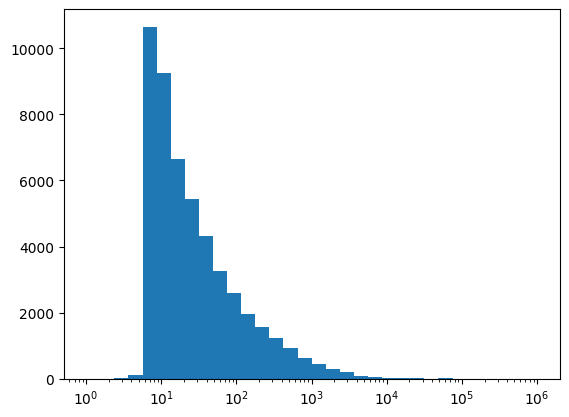

In [ ]:
plt.hist(token_freq_dict.values(), bins=10**np.linspace(0,6,33))
plt.xscale("log")

<a id="13"></a>
## 🎯 Q1.3: **Build Pytorch Dataset**.

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;color:#424242;">

**We build a Pytorch Dataset using cleaned `wikitext_dataset`:**

- **Step 1**: we have to add some special tokens for each sequence:
  - `<start>`: add to the start of a sequence;
  - `<stop>`: add to the end of a sequence;
  - `<pad>`: padding token. add padding token until the length of the sequence reach `MAX_SEQ_LENGTH`.

- **Step 2**: when we fetch a sequence in the dataset by indexing, it should return a sequence of token indices.

**TODO🔻: Implement `__init__` and `__getitem__` function in `RNNDataset` class in `data.py`**.

Detailed instructions are provided in the function description.
</div>


In [ ]:
from data import RNNDataset

# ETS: take ~1min to run #
MAX_SEQ_LENGTH = 128
rnn_dataset = RNNDataset(dataset=wikitext_dataset,
                         max_seq_length=MAX_SEQ_LENGTH)

Getting the vocabulary for the train dataset


100%|██████████| 97536/97536 [00:07<00:00, 13673.28it/s]


In [ ]:

test_rnn_dataset(rnn_dataset)

Test1 Passed ✅
Test2 Passed ✅


<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;color:#424242;">

**Once we create the `rnn_dataset`, we have to split it into train/test dataset, and build a DataLoader for each::**

- **Step 1**: split `rnn_dataset` into train/test datasets, with `test_ratio=0.1`:

- **Step 2**: Build pytorch dataloader for train/test dataset with `batch_size=8`.

**TODO🔻: Implement `get_dataloader` function in `data.py`**.

Detailed instructions are provided in the function description.
</div>


In [ ]:
from data import get_dataloader

# ETS: ~1min #
train_dataloader, test_dataloader = get_dataloader(rnn_dataset, test_ratio=0.1)

In [ ]:
test_dataloaders(train_dataloader, test_dataloader)

Test1 Passed ✅
Test1 Passed ✅


<div style="padding:15px 15px 15px 15px;border-left:3px solid #8e7cc3;background-color:#e4e1eb;border-radius: 15px;color:#424242;">

🎉 **Excellent work!** By this point, we have all core building blocks for Part 2 :)
   
- [X] `rnn_dataset`: A `Dataset` obj with the data, the vocabulary, the pad index, and mapping from tokens to indices;
- [X] `train_dataloader`: A `DataLoader` obj with training sequences;
- [X] `test_dataloader`: A `DataLoader` obj with testing sequences.

_Tip: Try to familiarize with functionalities and attributes they provide._
    
</div>

---

<a id="2"></a>
# PART 2:  Training Language Models

#### Language Model: a probabilistic model of a sequence of tokens.

🔵 **What?**

Language modeling (LM) is the use of various statistical and probabilistic techniques to determine the probability of a given sequence of words occurring in a sentence. Language models analyze bodies of text data to provide a basis for their word predictions. They are used in natural language processing (NLP) applications, particularly ones that generate text as an output. Some of these applications include, machine translation and question-answering.

🟡 **How?**

There are several different probabilistic approaches to modeling language, which vary depending on the purpose of the language model. From a technical perspective, the various types differ by the amount of text data they analyze and the math they use to analyze it (architecture). Some LMs we've already seen and will learn about during lectures are n-gram / count-based models, Recurrent Neural Networks (RNNs), and Transformer models.

🟣 **Why?**

Language modeling is crucial in modern NLP applications. It is the reason that machines can understand qualitative information. Each language model type, in one way or another, turns qualitative information into quantitative information. This allows people to communicate with machines as they do with each other to a limited extent. It is used directly in a variety of industries including tech, finance, healthcare, transportation, legal, military and government. Additionally, it's likely most people reading this have interacted with a language model in some way at some point in the day, whether it be through Google search, an autocomplete text function or engaging with a voice assistant.

ℹ️ Source: [Original article](https://www.techtarget.com/searchenterpriseai/definition/language-modeling#:~:text=Language%20models%20determine%20word%20probability,predict%20or%20produce%20new%20sentences.)



<div style="padding:15px 15px 15px 15px;border-left:3px solid gray;background-color:#F3F3F3;border-radius: 15px;color:#424242;">

**In this part, you will train your own language models using the dataset created in Part 1.**

You need to implement **3 different model variants**;
train and evaluate their perplexity.
    
| Model | Variant | Description |
|:---- |:----- | :----- |
|**LSTM** | Token embeddings trained from scratch | An LSTM model with a trainable token Embedding layer <br>that will be initialized randomly and trained from scratch along with the LM. |
| | Pre-trained token embeddings| An LSTM model with pre-trained GloVe embeddings as input <br>that will be ***frozen*** while the LM is training. |
| **Transformer** | Trained from scratch | A Transformer based model that follows the architecture of [DistilGPT2](https://huggingface.co/distilgpt2). |
    
</div>

<a id="21"></a>
## 🎯 Q2.1: **Vanilla LSTM**.


<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;color:#424242;">

**First, we train a vanilla LSTM on our train/test dataLoaders:**

- **Step 1**: Build the `VanillaLSTM` class, which takes:
  - `vocab_size`: size of vocabulary,
  - `embedding_dim`: dimension of token embedding,
  - `hidden_dim`: hidden dimension of lstm layer;
  - `num_layers`: number of stacked lstm layers;
  - `embedding_weights`: pretrained embedding weights. Train from scratch if set to `None`. Default: None;
  - `freeze_embeddings`: whether to freeze pretrained embeddings. Only be functional when `embedding_weights` is not None.

- **Step 2**: Train the LSTM model with `train_dataloader`. We usually run only one epoch for language modelling task to prevent overfitting;

- **Step 3**: Evaluate the LSTM by perplexity scores on `test_dataloader`.

**TODO🔻: Implement `VanillaLSTM`, `train_lstm` and `test_lstm` function in `modeling.py`**.

Detailed instructions are provided in the function description.
</div>


#### **LSTM from Scratch**

We here train the LSTM embedding weights from scratch. The dimension of embedding is defined as `embedding_dim`.

We set the `embedding_dim` as 100 here to compare with gensim pretrained embeddings.

In [ ]:
from modeling import VanillaLSTM

# Define the parameters to VanillaLSTM
## Hint: what do we have from Part1?
vocab_size = len(rnn_dataset.token2idx)
embedding_dim = 100
hidden_dim = 100
num_layers = 2
dropout_rate = 0.15
lr = 1e-3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model = VanillaLSTM(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)

In [ ]:
test_lstm_scratch(model)

Test Passed ✅


##### Train&Evaluation (LSTM-scratch)

In [ ]:
# Define optimizer and criterion (loss function)
## Hint: what do we have from Part1?
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index=rnn_dataset.pad_idx)

In [ ]:
from modeling import train_lstm, test_lstm

# ETS: take ~30mins for training #
train_lstm(model, train_dataloader, optimizer, criterion, device=device, tensorboard_path="./tensorboard/lstm_scratch")
torch.save(model.state_dict(), 'models/lstm_scratch.pt')
test_lstm(model, test_dataloader, criterion, device=device)

  5%|▍         | 502/10973 [00:54<19:00,  9.18it/s]

[Step   501] loss: 6.337


  9%|▉         | 1002/10973 [01:48<18:03,  9.20it/s]

[Step  1001] loss: 4.556


 14%|█▎        | 1502/10973 [02:43<17:10,  9.19it/s]

[Step  1501] loss: 3.697


 18%|█▊        | 2002/10973 [03:37<16:15,  9.19it/s]

[Step  2001] loss: 3.052


 23%|██▎       | 2502/10973 [04:32<15:22,  9.18it/s]

[Step  2501] loss: 2.551


 27%|██▋       | 3002/10973 [05:26<14:30,  9.15it/s]

[Step  3001] loss: 2.185


 32%|███▏      | 3502/10973 [06:20<13:32,  9.19it/s]

[Step  3501] loss: 1.886


 36%|███▋      | 4002/10973 [07:15<12:43,  9.13it/s]

[Step  4001] loss: 1.642


 41%|████      | 4502/10973 [08:09<11:45,  9.18it/s]

[Step  4501] loss: 1.442


 46%|████▌     | 5002/10973 [09:03<10:49,  9.20it/s]

[Step  5001] loss: 1.266


 50%|█████     | 5502/10973 [09:58<09:56,  9.17it/s]

[Step  5501] loss: 1.123


 55%|█████▍    | 6002/10973 [10:52<09:02,  9.16it/s]

[Step  6001] loss: 1.011


 59%|█████▉    | 6502/10973 [11:46<08:05,  9.20it/s]

[Step  6501] loss: 0.900


 64%|██████▍   | 7002/10973 [12:41<07:12,  9.18it/s]

[Step  7001] loss: 0.816


 68%|██████▊   | 7502/10973 [13:35<06:18,  9.18it/s]

[Step  7501] loss: 0.730


 73%|███████▎  | 8002/10973 [14:30<05:23,  9.18it/s]

[Step  8001] loss: 0.669


 77%|███████▋  | 8502/10973 [15:24<04:30,  9.15it/s]

[Step  8501] loss: 0.607


 82%|████████▏ | 9002/10973 [16:18<03:34,  9.19it/s]

[Step  9001] loss: 0.563


 87%|████████▋ | 9502/10973 [17:13<02:38,  9.27it/s]

[Step  9501] loss: 0.523


 91%|█████████ | 10002/10973 [18:07<01:45,  9.18it/s]

[Step 10001] loss: 0.486


 96%|█████████▌| 10502/10973 [19:01<00:51,  9.14it/s]

[Step 10501] loss: 0.456


100%|██████████| 10973/10973 [19:53<00:00,  9.20it/s]


Epoch Loss: 1.6811


100%|██████████| 1220/1220 [01:10<00:00, 17.28it/s]

Test loss: 0.221
Test Perplexity: 1.248


(0.22125847056263784, tensor(1.2476))

#### **LSTM with Pretrained Embeddings**

We first download the gensim embeddings, then fix the embedding layer in the LSTM model.

In [ ]:
from modeling import VanillaLSTM
from modeling import train_lstm, test_lstm

In [ ]:
import gensim.downloader
# Download the "glove-wiki-gigaword-100" embeddings
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-100')
initial_embedding_weight = torch.nn.Embedding(len(rnn_dataset.token2idx),
                                              embedding_dim).weight.detach().numpy()

# Get the pretrained embeddings from gensim for each tokens
for word_type, idx in rnn_dataset.token2idx.items():
  if word_type in glove_vectors.key_to_index.keys():
      initial_embedding_weight[idx] = glove_vectors[word_type]

In [ ]:
# Define the parameters to VanillaLSTM
## Hint: Use the same params as LSTM_scratch
vocab_size = len(rnn_dataset.token2idx)
embedding_dim = 100
hidden_dim = 100
num_layers = 2
dropout_rate = 0.15
lr = 1e-3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model = VanillaLSTM(vocab_size, embedding_dim, hidden_dim,
                    num_layers, dropout_rate=dropout_rate,
                    embedding_weights=initial_embedding_weight,
                    freeze_embeddings=True).to(device)

## Define optimizer and criterion
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index=rnn_dataset.pad_idx)

In [ ]:
test_lstm_pretrained(model)

Test Passed ✅


##### Train&Evaluation (LSTM-pretrained)

In [ ]:
train_lstm(model, train_dataloader, optimizer, criterion, device=device, tensorboard_path="./tensorboard/lstm_pretrained")
torch.save(model.state_dict(), 'models/lstm_pretrained.pt')
test_lstm(model, test_dataloader, criterion, device=device)

  5%|▍         | 502/10973 [00:54<18:55,  9.22it/s]

[Step   501] loss: 6.639


  9%|▉         | 1002/10973 [01:48<17:55,  9.27it/s]

[Step  1001] loss: 4.892


 14%|█▎        | 1502/10973 [02:42<17:02,  9.26it/s]

[Step  1501] loss: 4.028


 18%|█▊        | 2002/10973 [03:36<16:09,  9.26it/s]

[Step  2001] loss: 3.423


 23%|██▎       | 2502/10973 [04:30<15:18,  9.22it/s]

[Step  2501] loss: 2.962


 27%|██▋       | 3002/10973 [05:24<14:25,  9.21it/s]

[Step  3001] loss: 2.596


 32%|███▏      | 3502/10973 [06:18<13:28,  9.24it/s]

[Step  3501] loss: 2.298


 36%|███▋      | 4002/10973 [07:12<12:31,  9.27it/s]

[Step  4001] loss: 2.023


 41%|████      | 4502/10973 [08:06<11:42,  9.22it/s]

[Step  4501] loss: 1.819


 46%|████▌     | 5002/10973 [09:00<10:46,  9.23it/s]

[Step  5001] loss: 1.645


 50%|█████     | 5502/10973 [09:54<09:53,  9.21it/s]

[Step  5501] loss: 1.473


 55%|█████▍    | 6002/10973 [10:48<09:00,  9.20it/s]

[Step  6001] loss: 1.347


 59%|█████▉    | 6502/10973 [11:42<08:05,  9.22it/s]

[Step  6501] loss: 1.239


 64%|██████▍   | 7002/10973 [12:36<07:10,  9.23it/s]

[Step  7001] loss: 1.129


 68%|██████▊   | 7502/10973 [13:30<06:15,  9.24it/s]

[Step  7501] loss: 1.055


 73%|███████▎  | 8002/10973 [14:24<05:20,  9.26it/s]

[Step  8001] loss: 0.976


 77%|███████▋  | 8502/10973 [15:19<04:27,  9.25it/s]

[Step  8501] loss: 0.908


 82%|████████▏ | 9002/10973 [16:13<03:34,  9.19it/s]

[Step  9001] loss: 0.848


 87%|████████▋ | 9502/10973 [17:07<02:39,  9.24it/s]

[Step  9501] loss: 0.806


 91%|█████████ | 10002/10973 [18:01<01:45,  9.20it/s]

[Step 10001] loss: 0.760


 96%|█████████▌| 10502/10973 [18:55<00:51,  9.21it/s]

[Step 10501] loss: 0.718


100%|██████████| 10973/10973 [19:46<00:00,  9.25it/s]


Epoch Loss: 2.0157


100%|██████████| 1220/1220 [01:10<00:00, 17.27it/s]

Test loss: 0.446
Test Perplexity: 1.562


(0.4461387795869444, tensor(1.5623))

#### **Compare LSTM-scratch and LSTM-pretrained?**

**TODO🔻: compare the *performance* and *training efficiency* between `LSTM-scratch` and `LSTM-pretrained`**.



ans:

Results for the LSTM-scratch model, we have :
- Epoch Loss: 1.6811
- Test Loss: 0.221
- Test Perplexity: 1.248
- Training time : ~19:53 minutes
- Iterations per Second : ~9.20 it/s


Results for the LSTM-pretrained model, we have :
- Epoch Loss: 2.0157
- Test Loss: 0.446
- Test Perplexity: 1.562
- Training time : ~19:46 minutes
- Iterations per Second : ~9.20 it/s


The LSTM trained from scratch has a lower epoch loss and a lower test loss than the pretrained model. Thus it has fit the training data slightly better during the last epoch of training and performs better on the unseen data. Since a lower perplexity indicates a better prediction and in this case, the LSTM trained from scratch has a lower test perplexity, it predicts the test data more accurately than the pretrained model.

Thus, the LSTM model trained from scratch performs better than the pretrained LSTM in terms of both loss and perplexity on the test data. One reason would be that the scratch model has learned more effectively from the specific training dataset provided, leading to better generalization on the test set.

Also having a test loss lower than the training loss can be explained due to data leakage between the train and test data because in this assignment we didn't perform any checks to make sure texts came from different articles in Wikipedia. (From Ed)

Concerning the training efficiency, it took both of them approximately 20 minutes to run with 9.20 iterations per second which looks decent.

Thus there is not much difference in training effienciy, one reason is that the computational cost of other layers (such as LSTM or linear layers) dominates. Indeed, my initial belief was that the computational cost of the embedding layer will be reduced compared to training embeddings from scratch because there are no updates to compute during backpropagation.


<a id="22"></a>
## 🎯 Q2.2: **Train a Transformer: DistillGPT2**.


<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;color:#424242;">

**We train a DistillGPT2 on our train/test dataLoaders:**

- **Step 1**: Rebuild the datasets and dataloaders using huggingface tokenizer;

- **Step 2**: Train a DistilGPT2 efficiently using Trainer form `transformers`.

- **Step 3**: Evaluate perplexity scores on `test_dataloader`.

**TODO🔻: follow the instructions below**.
</div>

In [ ]:
from transformers import AutoConfig, AutoModelWithLMHead, AutoTokenizer, DataCollatorForLanguageModeling, Trainer, TrainingArguments

model_name = "distilgpt2"
tokenizer_checkpoint = "distilgpt2"

In [ ]:
MAX_SEQ_LENGTH = 128

# Load model from scratch
model_config = AutoConfig.from_pretrained(model_name)
gpt2_scratch_model = AutoModelWithLMHead.from_config(model_config)
gpt_tokenizer = AutoTokenizer.from_pretrained(model_name)
gpt_tokenizer.pad_token = gpt_tokenizer.eos_token

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1571: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

#### **Tokenize Datasets**
 Huggingface provides pretrained tokenizer for `DistilGPT2`, so we have to tokenize our dataset with this tokenizer.

**TODO🔻: Implement `get_encoded_dataset`**.

In [ ]:
def get_encoded_dataset(wikitext_dataset):
  # TODO: Tokenize wikitext_dataset with DistilGPT2 tokenizer. Padding to `max_length`.
  encoded_dataset = wikitext_dataset.map(lambda example : gpt_tokenizer(example['text'],
                                padding='max_length',
                                max_length=MAX_SEQ_LENGTH,
                                truncation=True))

  # TODO: Filter out samples longer than MAX_SEQ_LENGTH=128
  encoded_dataset = encoded_dataset.filter(lambda example: len(example["input_ids"]) <= MAX_SEQ_LENGTH)

  encoded_dataset = encoded_dataset.map(
    lambda example: {"input_ids": example['input_ids'][:MAX_SEQ_LENGTH],
                     "attention_mask": example["attention_mask"][:MAX_SEQ_LENGTH]})

  encoded_dataset = encoded_dataset.remove_columns("text")
  encoded_dataset = encoded_dataset.with_format("torch")
  encoded_dataset = encoded_dataset.map(lambda example:{"labels": example["input_ids"]})
  return encoded_dataset

## ETS: ~10mins to run.
encoded_dataset = get_encoded_dataset(wikitext_dataset)
transformer_train_dataset, transformer_test_dataset = torch.utils.data.random_split(encoded_dataset,
                                                               [int(len(encoded_dataset)*0.9), len(encoded_dataset)-int(len(encoded_dataset)*0.9)])

Map:   0%|          | 0/97536 [00:00<?, ? examples/s]

Filter:   0%|          | 0/97536 [00:00<?, ? examples/s]

Map:   0%|          | 0/97536 [00:00<?, ? examples/s]

Map:   0%|          | 0/97536 [00:00<?, ? examples/s]

#### **Build Trainer**
 Huggingface provides very efficient `Trainer` wrapper for language model training and evaluation.

**TODO🔻: Run the following blocks to define the training arguements and trainer, then start training simply by `trainer.train()`**.

In [ ]:
data_collator = DataCollatorForLanguageModeling(tokenizer=gpt_tokenizer, mlm=False)
training_args = TrainingArguments(
    output_dir=f"{model_name}-wikitext103",
    evaluation_strategy = "steps",
    num_train_epochs = 1.0,
    logging_steps=500,
    learning_rate=2e-5,
    save_steps=1000,
    weight_decay=0.01,
    report_to="tensorboard",
    logging_dir="./tensorboard/distilgpt2-scratch")

trainer = Trainer(
    model=gpt2_scratch_model,
    args=training_args,
    tokenizer=gpt_tokenizer,
    train_dataset=transformer_train_dataset,
    eval_dataset=transformer_test_dataset,
    data_collator=data_collator,)

In [ ]:
# ETS: ~20mins to run.
trainer.train()
trainer.save_model('models/distilgpt2_scratch')

Step,Training Loss,Validation Loss
500,7.157300,6.429574
1000,6.307600,6.167884
1500,6.121300,6.009262
2000,5.995200,5.882381
2500,5.891800,5.785487
3000,5.794300,5.707376
3500,5.743500,5.634935
4000,5.666600,5.577169
4500,5.611200,5.526027
5000,5.559700,5.481082


**TODO🔻: Run evaluation by `trainer.evaluate()`**.

In [ ]:
# ETS: ~1min to run.
eval_result = trainer.evaluate()
perplexity_from_scratch = math.exp(eval_result["eval_loss"])
print(f"The perplexity on the test dataset is {perplexity_from_scratch:.3f}")

The perplexity on the test dataset is 188.599


#### **Compare to the Pretrained DistilGPT2**

**TODO🔻: Load the pretrained `DistilGPT2` checkpoint from Huggingface.
We only run evaluation of the `trainsformer_test_dataset` here. Compare the performance between `gpt2_scratch_model` and `gpt2_pretrained_model`.**.

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import Trainer, TrainingArguments

model_id = "distilgpt2"
gpt2_pretrained_model = AutoModelForCausalLM.from_pretrained(model_id)
tokenizer_pretrained_gpt = AutoTokenizer.from_pretrained(model_id)
tokenizer_pretrained_gpt.pad_token = tokenizer_pretrained_gpt.eos_token


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
training_args = TrainingArguments(
    output_dir=f"pretrained_{model_id}-wikitext103",
    evaluation_strategy = "steps",
    num_train_epochs = 1.0,
    logging_steps=500,
    learning_rate=2e-5,
    save_steps=1000,
    weight_decay=0.01,
    report_to="tensorboard",
    logging_dir="./tensorboard/distilgpt2-pretrained")

pretrained_trainer = Trainer(
    model=gpt2_pretrained_model,
    args=training_args,
    tokenizer=tokenizer_pretrained_gpt,
    train_dataset=transformer_train_dataset,
    eval_dataset=transformer_test_dataset,
    data_collator=data_collator,)

In [ ]:
# ETS: ~1min.
eval_result = pretrained_trainer.evaluate()
perplexity_pretrained_model = math.exp(eval_result["eval_loss"])
print(f"The perplexity of pretrained {model_id} on the test dataset is {perplexity_pretrained_model:.3f}")

The perplexity of pretrained distilgpt2 on the test dataset is 103.047


<div style="padding:15px 15px 15px 15px;border-left:3px solid #8e7cc3;background-color:#e4e1eb;border-radius: 15px;color:#424242;">
    
🎉  **Excellent work!** We have completed Langauge Modelling tasks!

#### Part 2 - Checklist
Here are the core building blocks you created and that you will need for Part 3:
   
- [X] LSTM-variants checkpoints.
- [X] LSTM-variants ppl scores.
- [X] Transformer-variants ppl scores.

</div>

Just before you move on to the Part 3, let's save a few things which we will use in the Part 3 so that you don't have to run Part 1 and 2 every time.

#### Save wikitext vocabulary

In [ ]:
from utils import save_binary

save_binary(rnn_dataset.dataset_vocab, "wikitext_vocab.pkl")

---

<a id="3"></a>
# PART 3: Fine-tune on the Text Simplification task 🚀

In this part we will fine-tune and test language models on the downstream task of text simplification (a.k.a text compression). In this task, given a piece of text, the goal is to simplify (or compress) this text by extracting the most important information from it. We will consider encoder-decoder models built on top of the LSTM models you built in Part 2 and also pretrained transformer models from Huggingface.

Hence, there will be two sections in this final part of the assignment:
- [3.1 Finetune a custom Encoder-Decoder model on text simplification task](#32)
- [3.2 Finetune pretrained T5 model (an encoder-decoder) model on text simplification task](#33)

### Dataset
In this part, we will use a sentence compression [dataset](https://huggingface.co/datasets/embedding-data/sentence-compression) available on Huggingface. Each row in this dataset contains two sentences: the original sentence and the simplified one.

An example from this dataset is the following:

**Original sentence:** "The JSE kept toying with an all time high by midday today as resources continued to fuel the bourse."

**Simplified sentence:** "JSE keeps toying with all time high"

This dataset contains around 180k examples, but we will only use a subset of it.

### Load and preprocess sentence-compression dataset

In [ ]:
# We will use NLTK to tokenize the text
from datasets import load_dataset
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
scomp = load_dataset("embedding-data/sentence-compression")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Let's inspect the dataset. Note that this dataset only contains a train split (we will create our own train, validation and test sets from this split later)

In [ ]:
scomp["train"][0]

{'set': ["The USHL completed an expansion draft on Monday as 10 players who were on the rosters of USHL teams during the 2009-10 season were selected by the League's two newest entries, the Muskegon Lumberjacks and Dubuque Fighting Saints.",
  'USHL completes expansion draft']}

First to make our dataset and sentences smaller, let's filter examples where the original sentence has more than 10 and less than 100 words.

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;color:#424242;">

🎯 Goal: Keep only the examples that has more than 10 and less than 100 words in its original sentence.

</div>

In [ ]:
def filter_nbr_words(example):
    word_count = len(nltk.word_tokenize(example['set'][0]))
    return 10 < word_count < 100

# Apply the filter to the dataset
scomp_small = scomp.filter(filter_nbr_words)

Filter:   0%|          | 0/180000 [00:00<?, ? examples/s]

Next, let's define our train, validation and test sets of size 10k, 1k, and 1k respectively and also get rid of the 'set' attribute.

In [ ]:
scomp_train, scomp_val, scomp_test = scomp_small["train"][:10000]['set'], scomp_small["train"][10000:11000]['set'], scomp_small["train"][11000:12000]['set']

<a id="22"></a>
## 🎯 Q3.1: **Finetune custom encoder-decoder model on sentence simplification task**.


<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px; color:#424242;">

**In this section, we will build a model based on the [encoder-decoder architecture](https://arxiv.org/abs/1409.3215) and finetune it on our text simplification task. As you probably know by now that vanilla encoder-decoder models do not perform well when we have long-range dependencies. Therefore, we will build one where the decoder uses [additive attention](https://arxiv.org/abs/1409.0473) over encoder outputs. You will need to finish the following main steps:**

- **Step 1**: Implement a Tokenizer

- **Step 2**: Build a Pytorch Dataset

- **Step 3**: Implement an Encoder-Decoder Model

- **Step 4**: Finetune the model on the task

- **Step 5**: Test and evaluate model performance

**TODO🔻: follow the instructions below**.
</div>

### Implement a tokenizer
We will first implement a tokenizer for our dataset. This tokenizer will take our vocabulary from the Part 1 and will have methods to encode a given text and decode a given text ids.

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;color:#424242;">

🎯 Goal:  **Go to `data.py` and implement the `CustomTokenizer` class.**
    
</div>

Let's first load our wikitext vocabulary from Part 1.

In [ ]:
from utils import load_binary

wikitext_vocab = load_binary("wikitext_vocab.pkl")

Initialize the custom tokenizer with this vocabulary.

In [ ]:
from data import CustomTokenizer

custom_tokenizer = CustomTokenizer(vocab=wikitext_vocab)

### Implement a pytorch dataset
Now we will implement a Pytorch dataset that will represent our data in a suitable format for our model fine-tuning later.

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;color:#424242;">

🎯 Goal:  **Go to `data.py` and implement the `SCompDataset` class.**
    
</div>

Initialize train, validation and test pytorch datasets.

In [ ]:
from data import SCompDataset

MAX_SEQ_LENGTH = 128
scomp_train_ds = SCompDataset(scomp_train, custom_tokenizer, MAX_SEQ_LENGTH)
scomp_val_ds = SCompDataset(scomp_val, custom_tokenizer, MAX_SEQ_LENGTH)
scomp_test_ds = SCompDataset(scomp_test, custom_tokenizer, MAX_SEQ_LENGTH)

Initialize dataloaders for our datasets respectively.

In [ ]:
from torch.utils.data import DataLoader

# feel free to change batch size according to your GPU memory
scomp_train_dataloader = DataLoader(scomp_train_ds, batch_size=32, shuffle=True)
scomp_val_dataloader = DataLoader(scomp_val_ds, batch_size=32, shuffle=True)
scomp_test_dataloader = DataLoader(scomp_test_ds, batch_size=32, shuffle=True)

### Implement an Encoder-Decoder model
In this section, you will implement a model based on Encoder-Decoder architecture where the encoder will be one of the LSTM variants you implemented in Part 2. You will specifically implement an attention-based encoder-decoder where decoder attends over the encoder outputs to allow it to handle long range dependencies well.

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;color:#424242;">

🎯 Goal:  **Go to `modeling.py` and implement the `Encoder`, `AdditiveAttention`, `Decoder` and `EncoderDecoder` classes.**
    
</div>

Next we will load a pretrained encoder from Part 2. Choose the encoder that had best performance based on the perplexity metric.

In [ ]:
from modeling import VanillaLSTM

vocab_size = len(wikitext_vocab)
embedding_dim = 100
hidden_dim = 100
num_layers = 2
dropout_rate = 0.15

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

pretrained_encoder = VanillaLSTM(vocab_size, embedding_dim, hidden_dim,
                                  num_layers, dropout_rate=dropout_rate).to(device)

# TODO: Load the pretrained model from the file
state_dict = torch.load('models/lstm_pretrained.pt', map_location=device)
pretrained_encoder.load_state_dict(state_dict)

<All keys matched successfully>

Next we will need to implement training, evaluation and generation methods.

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;color:#424242;">

🎯 Goal:  **Go to `modeling.py` and implement the `seq2seq_train`, `seq2seq_eval` and `seq2seq_generate` functions.**
    
</div>

Now we are ready to finetune our encoder-decoder models on the sentence simplification dataset.

In [ ]:
from modeling import EncoderDecoder

lr = 0.001
dropout_rate =  0.15
bos_token_id = custom_tokenizer.bos_token_id
encoder_decoder = EncoderDecoder(hidden_dim, vocab_size, vocab_size, bos_token_id=bos_token_id, dropout_rate=dropout_rate, pretrained_encoder=pretrained_encoder).to(device)
optimizer = optim.Adam(encoder_decoder.parameters(), lr=lr)
criterion = nn.NLLLoss(ignore_index=custom_tokenizer.pad_token_id)
num_params = sum(p.numel() for p in encoder_decoder.parameters() if p.requires_grad)
print(f'The model has {num_params:,} trainable parameters')

The model has 20,566,967 trainable parameters


In [21]:
from modeling import seq2seq_train

# I used the model without early stopping since it yields better result and well-formed sentences
# ETS: ~30 mins to run with a batch size of 32 for 20 epochs
seq2seq_train(model=encoder_decoder,
              train_loader=scomp_train_dataloader,
              eval_loader=scomp_val_dataloader,
              optimizer=optimizer,
              criterion=criterion,
              device=device,
              tensorboard_path="./tensorboard/encoder_decoder")
# save the model
torch.save(encoder_decoder.state_dict(), "models/encoder_decoder.pt")

 32%|███▏      | 100/313 [00:28<00:57,  3.68it/s]

[1,   100] loss: 8.164



 64%|██████▍   | 200/313 [00:57<00:31,  3.59it/s]

[1,   200] loss: 7.411



 96%|█████████▌| 300/313 [01:25<00:03,  3.57it/s]

[1,   300] loss: 7.302



100%|██████████| 313/313 [01:28<00:00,  3.65it/s]
                                                 

Epoch 1 | Train Loss: 7.6100



  5%|▌         | 1/20 [01:32<29:25, 92.92s/it]

Epoch 1 | Eval Loss: 7.3553



 32%|███▏      | 100/313 [00:27<01:00,  3.52it/s]

[2,   100] loss: 6.967



 64%|██████▍   | 200/313 [00:55<00:29,  3.80it/s]

[2,   200] loss: 6.985



 96%|█████████▌| 300/313 [01:23<00:03,  3.70it/s]

[2,   300] loss: 6.963



100%|██████████| 313/313 [01:26<00:00,  3.58it/s]
                                                 

Epoch 2 | Train Loss: 6.9727



 10%|█         | 2/20 [03:03<27:33, 91.84s/it]

Epoch 2 | Eval Loss: 7.2675



 32%|███▏      | 100/313 [00:27<00:58,  3.65it/s]

[3,   100] loss: 6.827



 64%|██████▍   | 200/313 [00:55<00:32,  3.43it/s]

[3,   200] loss: 6.822



 96%|█████████▌| 300/313 [01:23<00:03,  3.51it/s]

[3,   300] loss: 6.804



100%|██████████| 313/313 [01:27<00:00,  3.59it/s]
                                                 

Epoch 3 | Train Loss: 6.8170



 15%|█▌        | 3/20 [04:35<25:57, 91.63s/it]

Epoch 3 | Eval Loss: 7.1883



 32%|███▏      | 100/313 [00:27<00:58,  3.64it/s]

[4,   100] loss: 6.610



 64%|██████▍   | 200/313 [00:55<00:31,  3.58it/s]

[4,   200] loss: 6.641



 96%|█████████▌| 300/313 [01:23<00:03,  3.63it/s]

[4,   300] loss: 6.651



100%|██████████| 313/313 [01:27<00:00,  3.73it/s]
                                                 

Epoch 4 | Train Loss: 6.6328



 20%|██        | 4/20 [06:06<24:25, 91.57s/it]

Epoch 4 | Eval Loss: 7.1484



 32%|███▏      | 100/313 [00:27<00:57,  3.73it/s]

[5,   100] loss: 6.402



 64%|██████▍   | 200/313 [00:55<00:31,  3.63it/s]

[5,   200] loss: 6.464



 96%|█████████▌| 300/313 [01:23<00:03,  3.52it/s]

[5,   300] loss: 6.472



100%|██████████| 313/313 [01:27<00:00,  3.76it/s]
                                                 

Epoch 5 | Train Loss: 6.4482



 25%|██▌       | 5/20 [07:38<22:53, 91.56s/it]

Epoch 5 | Eval Loss: 7.1140



 32%|███▏      | 100/313 [00:27<01:00,  3.51it/s]

[6,   100] loss: 6.235



 64%|██████▍   | 200/313 [00:55<00:30,  3.71it/s]

[6,   200] loss: 6.270



 96%|█████████▌| 300/313 [01:23<00:03,  3.50it/s]

[6,   300] loss: 6.283



100%|██████████| 313/313 [01:27<00:00,  3.74it/s]
                                                 

Epoch 6 | Train Loss: 6.2623



 30%|███       | 6/20 [09:09<21:20, 91.50s/it]

Epoch 6 | Eval Loss: 7.0784



 32%|███▏      | 100/313 [00:28<01:00,  3.54it/s]

[7,   100] loss: 6.038



 64%|██████▍   | 200/313 [00:56<00:30,  3.70it/s]

[7,   200] loss: 6.080



 96%|█████████▌| 300/313 [01:23<00:03,  3.40it/s]

[7,   300] loss: 6.122



100%|██████████| 313/313 [01:27<00:00,  3.82it/s]
                                                 

Epoch 7 | Train Loss: 6.0834



 35%|███▌      | 7/20 [10:41<19:50, 91.59s/it]

Epoch 7 | Eval Loss: 7.0894



 32%|███▏      | 100/313 [00:27<00:59,  3.56it/s]

[8,   100] loss: 5.838



 64%|██████▍   | 200/313 [00:55<00:30,  3.67it/s]

[8,   200] loss: 5.935



 96%|█████████▌| 300/313 [01:23<00:03,  3.68it/s]

[8,   300] loss: 5.970



100%|██████████| 313/313 [01:26<00:00,  3.80it/s]
                                                 

Epoch 8 | Train Loss: 5.9156



 40%|████      | 8/20 [12:12<18:16, 91.40s/it]

Epoch 8 | Eval Loss: 7.1330



 32%|███▏      | 100/313 [00:27<01:03,  3.35it/s]

[9,   100] loss: 5.678



 64%|██████▍   | 200/313 [00:55<00:31,  3.57it/s]

[9,   200] loss: 5.736



 96%|█████████▌| 300/313 [01:23<00:03,  3.61it/s]

[9,   300] loss: 5.835



100%|██████████| 313/313 [01:27<00:00,  3.55it/s]
                                                 

Epoch 9 | Train Loss: 5.7525



 45%|████▌     | 9/20 [13:44<16:45, 91.44s/it]

Epoch 9 | Eval Loss: 7.1641



 32%|███▏      | 100/313 [00:28<01:01,  3.46it/s]

[10,   100] loss: 5.517



 64%|██████▍   | 200/313 [00:55<00:31,  3.61it/s]

[10,   200] loss: 5.617



 96%|█████████▌| 300/313 [01:23<00:03,  3.72it/s]

[10,   300] loss: 5.663



100%|██████████| 313/313 [01:27<00:00,  3.51it/s]
                                                 

Epoch 10 | Train Loss: 5.6037



 50%|█████     | 10/20 [15:15<15:14, 91.46s/it]

Epoch 10 | Eval Loss: 7.2117



 32%|███▏      | 100/313 [00:27<00:58,  3.62it/s]

[11,   100] loss: 5.370



 64%|██████▍   | 200/313 [00:56<00:31,  3.61it/s]

[11,   200] loss: 5.484



 96%|█████████▌| 300/313 [01:24<00:03,  3.60it/s]

[11,   300] loss: 5.537



100%|██████████| 313/313 [01:27<00:00,  3.80it/s]
                                                 

Epoch 11 | Train Loss: 5.4646



 55%|█████▌    | 11/20 [16:47<13:45, 91.72s/it]

Epoch 11 | Eval Loss: 7.3399



 32%|███▏      | 100/313 [00:27<00:59,  3.58it/s]

[12,   100] loss: 5.238



 64%|██████▍   | 200/313 [00:55<00:31,  3.58it/s]

[12,   200] loss: 5.340



 96%|█████████▌| 300/313 [01:23<00:03,  3.60it/s]

[12,   300] loss: 5.418



100%|██████████| 313/313 [01:27<00:00,  3.56it/s]
                                                 

Epoch 12 | Train Loss: 5.3363



 60%|██████    | 12/20 [18:19<12:14, 91.79s/it]

Epoch 12 | Eval Loss: 7.4014



 32%|███▏      | 100/313 [00:28<01:00,  3.53it/s]

[13,   100] loss: 5.136



 64%|██████▍   | 200/313 [00:56<00:32,  3.49it/s]

[13,   200] loss: 5.225



 96%|█████████▌| 300/313 [01:25<00:03,  3.40it/s]

[13,   300] loss: 5.289



100%|██████████| 313/313 [01:29<00:00,  3.65it/s]
                                                 

Epoch 13 | Train Loss: 5.2204



 65%|██████▌   | 13/20 [19:53<10:46, 92.32s/it]

Epoch 13 | Eval Loss: 7.4726



 32%|███▏      | 100/313 [00:28<00:59,  3.61it/s]

[14,   100] loss: 5.021



 64%|██████▍   | 200/313 [00:56<00:31,  3.63it/s]

[14,   200] loss: 5.125



 96%|█████████▌| 300/313 [01:24<00:03,  3.60it/s]

[14,   300] loss: 5.166



100%|██████████| 313/313 [01:28<00:00,  3.75it/s]
                                                 

Epoch 14 | Train Loss: 5.1069



 70%|███████   | 14/20 [21:26<09:14, 92.49s/it]

Epoch 14 | Eval Loss: 7.5360



 32%|███▏      | 100/313 [00:28<01:00,  3.52it/s]

[15,   100] loss: 4.898



 64%|██████▍   | 200/313 [00:56<00:30,  3.67it/s]

[15,   200] loss: 5.007



 96%|█████████▌| 300/313 [01:24<00:03,  3.35it/s]

[15,   300] loss: 5.078



100%|██████████| 313/313 [01:28<00:00,  3.68it/s]
                                                 

Epoch 15 | Train Loss: 4.9966



 75%|███████▌  | 15/20 [22:58<07:42, 92.56s/it]

Epoch 15 | Eval Loss: 7.5831



 32%|███▏      | 100/313 [00:28<01:00,  3.54it/s]

[16,   100] loss: 4.786



 64%|██████▍   | 200/313 [00:56<00:31,  3.61it/s]

[16,   200] loss: 4.924



 96%|█████████▌| 300/313 [01:24<00:03,  3.53it/s]

[16,   300] loss: 4.949



100%|██████████| 313/313 [01:28<00:00,  3.56it/s]
                                                 

Epoch 16 | Train Loss: 4.8940



 80%|████████  | 16/20 [24:31<06:09, 92.50s/it]

Epoch 16 | Eval Loss: 7.6583



 32%|███▏      | 100/313 [00:28<01:03,  3.34it/s]

[17,   100] loss: 4.693



 64%|██████▍   | 200/313 [00:57<00:31,  3.57it/s]

[17,   200] loss: 4.814



 96%|█████████▌| 300/313 [01:25<00:03,  3.41it/s]

[17,   300] loss: 4.864



100%|██████████| 313/313 [01:29<00:00,  3.60it/s]
                                                 

Epoch 17 | Train Loss: 4.7956



 85%|████████▌ | 17/20 [26:04<04:38, 92.83s/it]

Epoch 17 | Eval Loss: 7.7178



 32%|███▏      | 100/313 [00:28<00:59,  3.56it/s]

[18,   100] loss: 4.597



 64%|██████▍   | 200/313 [00:56<00:31,  3.56it/s]

[18,   200] loss: 4.725



 96%|█████████▌| 300/313 [01:24<00:03,  3.70it/s]

[18,   300] loss: 4.765



100%|██████████| 313/313 [01:28<00:00,  3.70it/s]
                                                 

Epoch 18 | Train Loss: 4.6996



 90%|█████████ | 18/20 [27:37<03:05, 92.72s/it]

Epoch 18 | Eval Loss: 7.8128



 32%|███▏      | 100/313 [00:28<00:59,  3.60it/s]

[19,   100] loss: 4.489



 64%|██████▍   | 200/313 [00:56<00:31,  3.59it/s]

[19,   200] loss: 4.653



 96%|█████████▌| 300/313 [01:24<00:04,  3.22it/s]

[19,   300] loss: 4.689



100%|██████████| 313/313 [01:28<00:00,  3.43it/s]
                                                 

Epoch 19 | Train Loss: 4.6137



 95%|█████████▌| 19/20 [29:10<01:32, 92.79s/it]

Epoch 19 | Eval Loss: 7.9494



 32%|███▏      | 100/313 [00:28<00:59,  3.57it/s]

[20,   100] loss: 4.405



 64%|██████▍   | 200/313 [00:56<00:30,  3.65it/s]

[20,   200] loss: 4.549



 96%|█████████▌| 300/313 [01:24<00:03,  3.34it/s]

[20,   300] loss: 4.613



100%|██████████| 313/313 [01:28<00:00,  3.61it/s]
                                                 

Epoch 20 | Train Loss: 4.5285



100%|██████████| 32/32 [00:04<00:00,  7.41it/s]


Epoch 20 | Eval Loss: 7.9274


Now we have the finetuned encoder-decoder model, we will use it to generate simplified text from the test set and compute a rouge score.

In [22]:
from modeling import seq2seq_generate
test_generations = seq2seq_generate(encoder_decoder, scomp_test_dataloader, custom_tokenizer, device=device)

100%|██████████| 32/32 [00:04<00:00,  6.60it/s]


Inspect the generations. Do they look like reasonable outputs?

In [28]:
test_generations[5:10]

[{'input': 'computer giant announced it would cut jobs worldwide over three years as a result of its integration of electronic data systems',
  'reference': 'hp to cut jobs over three years',
  'prediction': 'facebook to'},
 {'input': 'the national press club on wednesday said that the local media should not be blamed for doing their jobs during the hostage crisis that happened in manila last august 23',
  'reference': 'media should not be blamed',
  'prediction': 'doctors should not not not not not not not not'},
 {'input': 'by cheryl running in the snow in their bare feet a houghton lake family escaped a trailer fire the morning of 28',
  'reference': 'family escapes trailer fire',
  'prediction': 'body'},
 {'input': 'phil hughes has been signed to english county team worcestershire for the upcoming season',
  'reference': 'phil hughes signs for worcestershire',
  'prediction': 'bryan coach to'},
 {'input': 'finally the euro has been dealt a downward correction as a result of an unex

Let's implement an evaluation function for ROUGE score.

**ROUGE score** stands for Recall-Oriented Understudy for Gisting Evaluation. In its simplest form ROUGE score is the quotient of the matching words under the total count of words in reference sentence. Regarding the denominator ROUGE is a recall oriented metric.

![rouge.png](docs/rouge.png)

**ROUGE-L score** is based on the length of the longest common subsequence (LCS). To counter the disadvantages of a pure recall metric as in ROUGE-N, Rouge-L calculates the weighted harmonic mean (or f-measure) combining the precision score and the recall score.

![rouge_l.png](docs/rouge_l.png)

ℹ️ Source: [Original article](https://clementbm.github.io/theory/2021/12/23/rouge-bleu-scores.html#bleu)

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;color:#424242;">

🎯 Goal:  **Go to `modeling.py` and implement the `evaluate_rouge` method.**
    
</div>

Calculate Rouge scores.

In [24]:
from modeling import evaluate_rouge

print(evaluate_rouge(test_generations))

{'rouge1': 0.05891526719808407, 'rouge2': 0.005379109597583438, 'rougeL': 0.058995531426207254, 'rougeLsum': 0.05902550409609439}


<a id="22"></a>
## 🎯 Q3.2: **Finetune pretrained T5 model on text simplification task**.


<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;color:#424242;">

**In this section, we will take a pretrained [T5](https://arxiv.org/abs/1910.10683) model which is also an encoder-decoder model but based on the transformer architecture and finetune it on our task. You will need to do the following main steps:**

- **Step 1**: Load T5 Model from Huggingface

- **Step 2**: Implement Pytorch dataset for this model

- **Step 3**: Run model finetuning

- **Step 4**: Test and evaluate model performance


**TODO🔻: follow the instructions below**.
</div>

Initialize T5 model from Huggingface pretrained model.

In [29]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_name = "t5-small"
t5_tokenizer = AutoTokenizer.from_pretrained(model_name)
# Make sure to put your model on the GPU
t5_model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Let's define a pytorch dataset for our T5 model.

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;color:#424242;">

🎯 Goal:  **Go to `modeling.py` and implement the `SCompT5Dataset` class.**
    
</div>

In [30]:
from data import ScompT5Dataset
scomp_t5_train_dataset = ScompT5Dataset(scomp_train, t5_tokenizer)
scomp_t5_val_dataset = ScompT5Dataset(scomp_val, t5_tokenizer)
scomp_t5_test_dataset = ScompT5Dataset(scomp_test, t5_tokenizer)

Prepare finetuning arguments

In [31]:
from transformers import TrainingArguments, Trainer

# create the finetuning trainer
# TODO: set the hyperparameters to reasonable values
training_args = TrainingArguments(
    output_dir=f"finetune_{model_name}-SCOMP",
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_steps=100,
    learning_rate=0.01,
    num_train_epochs=5,
    save_strategy="no",
    weight_decay=0.01,
    report_to="tensorboard",
    logging_dir="./tensorboard/t5-scomp")

#### Run the model finetuning

In [32]:
# Run in 20 min
trainer = Trainer(
    model=t5_model,
    args=training_args,
    train_dataset=scomp_t5_train_dataset,
    eval_dataset=scomp_t5_val_dataset
)

trainer.train()
trainer.save_model(f"models/finetune_{model_name}_scomp")

Epoch,Training Loss,Validation Loss
1,0.137600,0.129644
2,0.116400,0.119150
3,0.107200,0.115281
4,0.096300,0.114408
5,0.086300,0.114600


Now we will load our final finetuned model from the last checkpoint and evaluate it on the test set.

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [34]:
from transformers import T5ForConditionalGeneration
t5_model = T5ForConditionalGeneration.from_pretrained(f"models/finetune_{model_name}_scomp").to(device)

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;color:#424242;">

🎯 Goal:  **Go to `modeling.py` and implement the `t5_generate` method.**
    
</div>

In [35]:
from modeling import t5_generate

test_t5_generations = t5_generate(scomp_t5_test_dataset, t5_model, t5_tokenizer)

100%|██████████| 1000/1000 [02:57<00:00,  5.65it/s]


Let's inspect the generations. Are they better than the ones generated by the encoder-decoder model? Provide some reasons why one model's generations are better than the other.

In [36]:
test_t5_generations[:5]

[{'input': 'ICAP has sold a 12% stake in Traiana to seven of its leading customers, giving the business a valuation of $300m.',
  'reference': 'Icap sells 12% stake in Traiana',
  'prediction': "We will have a lot of money''"},
 {'input': 'BRITISH soul singer Amy Winehouse has undergone more tests after being taken to hospital four days ago, but hopes to perform as scheduled next week, her office said on Thursday.',
  'reference': 'British singer Amy Winehouse undergoes more tests',
  'prediction': "'I'm not me, too greedy'"},
 {'input': 'The new Scout.com 2012 rankings are out and loaded with Indiana players or those with ties to the state.',
  'reference': 'New Scout.com rankings loaded with Indiana players',
  'prediction': "'I'm not a bad thing'"},
 {'input': 'Arkansas held its first practice in full pads Saturday, but even then coaches saw the Razorbacks be a little tentative in making hits.',
  'reference': 'Arkansas holds first practice in full pads',
  'prediction': "'I'm not a

**Answer:**

Finally, let's compute the ROUGE scores.

In [37]:
from modeling import evaluate_rouge

print(evaluate_rouge(test_t5_generations))

{'rouge1': 0.04405086042698269, 'rouge2': 0.008711040348540349, 'rougeL': 0.043529647371946964, 'rougeLsum': 0.04345165777265275}


<div style="padding:15px 15px 15px 15px;border-left:3px solid #8e7cc3;background-color:#e4e1eb;border-radius: 15px;color:#424242;">

🎉 Excellent work! You just finished the code implementation parts of the assignment.

#### Part 3 - Checklist
Here are the elements you will need for the report in Part 4:

- [X] Finetuned encoder-decoder model and its rouge scores.
- [X] Finetuned T5 model and its rouge scores.
</div>

---

<a id="4"></a>
# PART 4: Write your report 📘

Fill in the tables with the respective scores.

<div style="padding:15px 15px 15px 15px;border-left:3px solid #03befc;background-color:#eff7fe;border-radius: 15px;text-align:center;color:#424242;">

#### Perplexity results on Language Models

| Model - Variant | PPL |
|:--------- | :-----: |
| LSTM Variant A - Embeddings trained from scratch |1.248|
| LSTM Variant B - Pre-trained embeddings & frozen | 1.562 |
||||
| DistilGPT2 - Trained from scratch | 188.599 |
| Pre-trained DistilGPT2 | 103.047 |
    
#### Performance scores on Text Simplification
| Model - Variant | ROUGE-1 | ROUGE-2 | ROUGE-L | ROUGE-Lsum |
|:--------- | :-----: | :-----: |  :-----: |  :-----: |
| Finetuned Encoder-Decoder| 0.0590 | 0.0053 | 0.0590 | 0.0590 |
| Finetuned T5 | 0.0441 | 0.0087 | 0.0435 | 0.0435 |

</div>

I already tried to specify within the code where I used it and the prompt questions and outputs.
I used ChatGPT, particularly in the `modeling.py` file for the Encoder-Decoder part, focusing on the decoder within the forward function. I mainly asked for help in understanding and writing code related to this part. While I also employed ChatGPT for some other sections of the assignement, it was for basic coding tasks not directly related to the specifics of the assignement.

For basic coding questions, ChatGPT succeeded with ease. However, when it came to understand complex algorithms, ChatGPT struggled. It usually outputs wrong responses. Despite attempting to refine my prompts, I found that ChatGPT still frequently produced outputs that required significant editing and refinement. On average, I had to make significant modifications to the outputs, often rewriting or restructuring sections of code to ensure correctness. Moreoever, when encountering errors within my code (Dimension errors especially), ChatGPT often failed to provide helpful solutions, leaving me to rely on other resources such as online forums and discussions for assistance and previous exercises.

Finally, ChatGPT was helpful for simple tasks but he was not always effective, particularly in contexts requiring deep understanding. For future assignments, I will continue to use it, recognizing their limitations.
